In [1]:
#Import libraries before starting
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

DATA_DIR = os.getenv('FINANCE_DATA_DIR', '../../data')

```markdown
## XGBoost and Random Forest for Detecting Fraudulent Transactions

Predict whether a transaction is a fraud or not.

compare XGBoost and RandomForest algorithms with and without SMOTE using F1 score and use 5-fold cross-validation .

Scenarios: Random Forest, XGBoost, Random Forest + SMOTE, XGBoost + SMOTE
```

In [3]:
#read data
file_to_load = f"{DATA_DIR}/creditcard.csv"
data = pd.read_csv(file_to_load, parse_dates =True)

In [4]:
# check and handle missing values
missing_values_columns = data.columns[data.isnull().any()]
print("Before: ", data.shape)
print("columns with missing values: ")
display(data[missing_values_columns].isnull().sum())
# for simplicity I will drop nans since there is arent any.
data.dropna(inplace=True)
print("After : ", data.shape)

Before:  (284807, 31)
columns with missing values: 


Series([], dtype: float64)

After :  (284807, 31)


**Check if dataset is balanced**

In [5]:
# check values of class

# create a lookup table for class
class_lookup = {0: 'Not Fraud', 1: 'Fraud'}


target_column = 'Class'
per_class_count = pd.DataFrame(data[target_column].value_counts())
per_class_count.rename(index=class_lookup, inplace=True)
per_class_count.rename(columns={"Class": 'Count'}, inplace=True)
print(per_class_count)
# per_class_count.plot.pie(y="Count", figsize=(10, 5), fontsize=17, autopct='%1.1f%%',grid=True, legend=False, title="Class Distribution")
# plt.ylabel("")



            Count
Not Fraud  284315
Fraud         492


``` python

"""
    With a balanced dataset we expect to see 50% of the data in each class.
    in this case we have 99.8% of the data in the not fraud class and 0.2% in the fraud class.
    This is a highly imbalanced dataset, thus will cause performance drop, and unstable learning.
"""

```

**XGBoost without SMOTE**

In [6]:
try:
    import xgboost
    import sklearn
    import imblearn
except:
    ! pip install xgboost -q
    ! pip install scikit-learn -q
    ! pip install imbalanced-learn -q

In [7]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

In [8]:
# separate the features from the target
X = data.drop('Class', axis=1)
y = data['Class']

# we will use the scikit-learn train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape} X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (227845, 30), y_train: (227845,) X_test: (56962, 30), y_test: (56962,)


In [9]:
# XGBOOST without SMOTE
# note that we are using all data

num_folds = 5
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
cv_results = cross_val_score(xgb_classifier, X, y, cv=num_folds, scoring='f1',verbose=5)

print(f"XGBOOST Averaged F1-Score  : {cv_results.mean():.2f}")


[CV] END ................................ score: (test=0.106) total time=  13.4s
[CV] END ................................ score: (test=0.847) total time=  13.5s
[CV] END ................................ score: (test=0.702) total time=  10.9s
[CV] END ................................ score: (test=0.885) total time=  11.1s
[CV] END ................................ score: (test=0.810) total time=  12.6s
XGBOOST Averaged F1-Score  : 0.67


In [10]:
# RandomForest  without SMOTE
# note that we are using all data

num_folds = 5
rf_classifier = RandomForestClassifier(random_state=42)
cv_results = cross_val_score(rf_classifier, X, y, cv=num_folds, scoring='f1',verbose=5)

print(f"Random Forest Averaged F1-Score : {cv_results.mean():.2f}")

[CV] END ................................ score: (test=0.003) total time= 2.6min
[CV] END ................................ score: (test=0.881) total time= 2.3min
[CV] END ................................ score: (test=0.733) total time= 2.3min
[CV] END ................................ score: (test=0.889) total time= 2.1min
[CV] END ................................ score: (test=0.800) total time= 2.2min
Random Forest Averaged F1-Score : 0.66


```python
""" 
XGBoost without SMOTE : 0.67
Random Forest without SMOTE : 0.66 

In terms of averaged F1 score for 5 folds,
We can say that on average XGBoost performs better than Random Forest.

In terms of computational time, XGBoost is faster than Random Forest.
"""
```

**with SMOTE**


In [11]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [12]:
# examine the class distribution
print(f"original size: {len(y)}")
print(f"resampled size: {len(y_resampled)}")
print(f"update distribution:\n{y_resampled.value_counts()}")

original size: 284807
resampled size: 568630
update distribution:
0    284315
1    284315
Name: Class, dtype: int64


In [13]:
# SGBOOST with smote
# note that we are using all resampled data

num_folds = 5
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
cv_results = cross_val_score(xgb_classifier, X_resampled, y_resampled, cv=num_folds, scoring='f1',verbose=5)

print(f"XGBOOST With smote Averaged F1-Score  : {cv_results.mean():.2f}")


[CV] END ................................ score: (test=0.690) total time=  30.8s
[CV] END ................................ score: (test=0.968) total time=  26.9s
[CV] END ................................ score: (test=0.996) total time=  24.9s
[CV] END ................................ score: (test=0.999) total time=  29.4s
[CV] END ................................ score: (test=0.747) total time=  27.1s
XGBOOST With smote Averaged F1-Score  : 0.88


In [14]:
# RandomForest  with SMOTE
# note that we are using all resampled data

num_folds = 5
rf_classifier = RandomForestClassifier(random_state=42)
cv_results = cross_val_score(rf_classifier, X_resampled, y_resampled, cv=num_folds, scoring='f1', verbose=5)

print(f"Random Forest with smote Averaged F1-Score : {cv_results.mean():.2f}")

[CV] END ................................ score: (test=0.737) total time= 4.1min
[CV] END ................................ score: (test=1.000) total time= 4.1min
[CV] END ................................ score: (test=1.000) total time= 4.0min
[CV] END ................................ score: (test=1.000) total time= 4.4min
[CV] END ................................ score: (test=0.712) total time= 4.3min
Random Forest with smote Averaged F1-Score : 0.89


```python

""" 
XGBoost with SMOTE : 0.88
Random Forest with SMOTE :   0.89


Overall we can conclude that Random Forest with SMOTE performs the best.
additionally, we can say that Random forest takes longer to train than XGBoost with average 3.5 mins vs 21.5 secs per fold.
"""
```

```markdown
## MLP for House Price Prediction

implement four MLPs: 

a- MLP with 1 hidden layer with 8 units in hidden layer

b- MLP with 1 hidden layer with 4 units in hidden layer

c- MLP with 2 hidden layers with 4 units in both first and second layers.

d- MLP with 2 hidden layers with 8 units in first layer and 4 units in the second layer.

predict house sale price and report performance in terms of R2 and RMSE for the test set by applying 5-fold cross-validation.

```

In [16]:
#1. load the data
path_to_data = Path(f'{DATA_DIR}/kaggle_house.csv')
columns_to_use = ["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea","Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]
data = pd.read_csv(path_to_data, usecols=columns_to_use, infer_datetime_format=True).dropna()
print(data.shape)


(1201, 10)


In [17]:
# encode categorical data using label encoding for simplicity
print(f"Before encoding: {data.shape}")
category_cols = data.select_dtypes(include=['object'], exclude=["number"]).columns
data[category_cols] = data[category_cols].apply(lambda x: x.astype('category').cat.codes)
print(f"After encoding: {data.shape}")

Before encoding: (1201, 10)
After encoding: (1201, 10)


In [18]:
#normalize all but target
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
normalized_data["SalePrice"] = data["SalePrice"]

In [19]:
# splits the data into train and test
from sklearn.model_selection import train_test_split

# separate the features from the target
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

# we will use the scikit-learn train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape} X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (960, 9), y_train: (960,) X_test: (241, 9), y_test: (241,)


In [20]:
try:
    import tensorflow
    import keras
    import tqdm
except:
    ! pip install tensorflow -q
    ! pip install keras -q
    ! pip install tqdm -q
    
    
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import KFold
from tqdm.keras import TqdmCallback

In [21]:
""" 
    Helper functions 
"""

def train_model(model, 
                X_train, 
                y_train,
                X_val,
                y_val, 
                epochs=200,
                loss = "mse",
                optimizer='nadam',
                learning_rate=0.001,
                batch_size=128, 
                verbose=1):
    """
    Train a model and return the history
    """
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1, patience=2, verbose=verbose, mode='auto') 
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_val, y_val),
                        batch_size = batch_size,
                        verbose=0,
                        epochs = epochs,
                        callbacks=[TqdmCallback(verbose=verbose),monitor]
                        )
    return history, model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate a model and return the score
    """
    y_pred = model.predict(X_test)
    
    results = {"rmse" : np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
               "r2" : metrics.r2_score(y_test, y_pred)
               }
    
    return results


In [22]:
def custom_cross_val_score(create_model,X,y,splits=5,epochs=200):
    
    best_model = {"model": None,"rmse-val-score": None, "history": None }
    kfolds_history = {"loss": [],  "val_loss": [], "rmse": [],  "val_rmse": [] }
    
    input_dim = X.shape[1]
    kfold = KFold(n_splits=splits, shuffle=True, random_state=42)
    
    for foldNo, (train_index, val_index) in enumerate(kfold.split(X_train)):
        print(f"[INFO] fold ...{foldNo}")           
        model = create_model(input_dim=input_dim)
        X_train_kfold, X_val_kfold = X.iloc[train_index], X.iloc[val_index]
        y_train_kfold, y_val_kfold = y.iloc[train_index], y.iloc[val_index]


        history , model = train_model(model = model,
                            X_train= X_train_kfold,
                            y_train= y_train_kfold,
                            X_val= X_val_kfold,
                            y_val= y_val_kfold,
                            epochs=epochs
                            )
        kfolds_history["loss"].append(history.history['loss'][-1])
        kfolds_history["val_loss"].append(history.history['val_loss'][-1])
        kfolds_history["rmse"].append(history.history['root_mean_squared_error'][-1])
        kfolds_history["val_rmse"].append(history.history['val_root_mean_squared_error'][-1])
        
        last_rmse = history.history['val_root_mean_squared_error'][-1]
        if  best_model["rmse-val-score"] is None or last_rmse < best_model["rmse-val-score"]:
            best_model["model"] = model
            best_model["rmse-val-score"] = last_rmse
            best_model["history"] = history
        
    return kfolds_history, best_model

In [23]:
best_models_reports = {}

```python 

"""
    for every model we will apply cross validation with 5 folds.
    The dataset is divided into Train and Test sets.

    the train set is partitioned into 5 folds.
    once the cross validation is done we select the best model based on the average R2 score.
    and we report the average R2 and RMSE for the test set.

    the test set will be used to evaluate the performance of the model against unseen data and compare the models.

"""
```

**a- MLP with 1 hidden layer with 8 units in hidden layer**


In [24]:
#model A
def create_model(input_dim):
    model = keras.Sequential(name="Model_A")
    model.add(keras.Input(shape=(input_dim,))) # input layer 
    model.add(Dense(8, activation='relu')) # hidden layer 8
    model.add(Dense(1, activation='linear')) # output layer 1
    # print(model.summary())
    return model


kfolds_history, best_model = custom_cross_val_score(create_model=create_model,
                                                        X=X_train, 
                                                        y=y_train, 
                                                        splits=5,
                                                        epochs=200
                                                        )    

print("CV results")
for key, values in kfolds_history.items():
    print(f"{key}: {np.mean(values):.3e}  {np.std(values):.3e}")
        
model = best_model["model"]
history = best_model["history"]

print("Performance on test data")
test_score = evaluate_model(model, X_test, y_test)
best_models_reports[model.name] = {}
best_models_reports[model.name]["model"] = model
best_models_reports[model.name]["history"] = history
best_models_reports[model.name]["test_score"] = test_score

print(f"Test Error for {model.name} ===  RMSE:{test_score['rmse']:.3e} | R2:{test_score['r2']:.3f}")


[INFO] fold ...0


100%|██████████| 200/200 [00:07<00:00, 25.95epoch/s, loss=1.83e+10, root_mean_squared_error=1.35e+5, val_loss=1.67e+10, val_root_mean_squared_error=1.29e+5]


[INFO] fold ...1


100%|██████████| 200/200 [00:06<00:00, 29.90epoch/s, loss=1e+10, root_mean_squared_error=1e+5, val_loss=8.24e+9, val_root_mean_squared_error=9.08e+4]       


[INFO] fold ...2


100%|██████████| 200/200 [00:06<00:00, 29.41epoch/s, loss=1.09e+10, root_mean_squared_error=1.05e+5, val_loss=1.16e+10, val_root_mean_squared_error=1.08e+5]


[INFO] fold ...3


100%|██████████| 200/200 [00:06<00:00, 28.97epoch/s, loss=6.04e+9, root_mean_squared_error=7.77e+4, val_loss=7.5e+9, val_root_mean_squared_error=8.66e+4]   


[INFO] fold ...4


100%|██████████| 200/200 [00:06<00:00, 29.61epoch/s, loss=9.48e+9, root_mean_squared_error=9.74e+4, val_loss=1.05e+10, val_root_mean_squared_error=1.02e+5] 


CV results
loss: 1.096e+10  4.032e+09
val_loss: 1.090e+10  3.250e+09
rmse: 1.030e+05  1.858e+04
val_rmse: 1.033e+05  1.501e+04
Performance on test data
8/8 [==============================] - 0s 1ms/step
Test Error for Model_A ===  RMSE:1.523e+05 | R2:-1.587



**b- MLP with 1 hidden layer with 4 units in hidden layer**


In [25]:
#model B
def create_model(input_dim):      
    model = keras.Sequential(name="Model_B")
    model.add(keras.Input(shape=(input_dim,)))  
    model.add(Dense(4, activation='relu')) 
    model.add(Dense(1, activation='linear')) 
    # print(model.summary())
    return model

kfolds_history, best_model = custom_cross_val_score(create_model=create_model,
                                                        X=X_train, 
                                                        y=y_train, 
                                                        splits=5,
                                                        epochs=200
                                                        )    

print("CV results")
for key, values in kfolds_history.items():
    print(f"{key}: {np.mean(values):.3e}  {np.std(values):.3e}")
        
model = best_model["model"]
history = best_model["history"]

print("Performance on test data")
test_score = evaluate_model(model, X_test, y_test)
best_models_reports[model.name] = {}
best_models_reports[model.name]["model"] = model
best_models_reports[model.name]["history"] = history
best_models_reports[model.name]["test_score"] = test_score

print(f"Test Error for {model.name} ===  RMSE:{test_score['rmse']:.3e} | R2:{test_score['r2']:.3f}")

[INFO] fold ...0


100%|██████████| 200/200 [00:06<00:00, 32.09epoch/s, loss=1.25e+10, root_mean_squared_error=1.12e+5, val_loss=1.12e+10, val_root_mean_squared_error=1.06e+5]


[INFO] fold ...1


  8%|▊         | 17/200 [00:01<00:10, 16.72epoch/s, loss=3.85e+10, root_mean_squared_error=1.96e+5, val_loss=3.67e+10, val_root_mean_squared_error=1.92e+5]

Epoch 17: early stopping


[INFO] fold ...2


100%|██████████| 200/200 [00:06<00:00, 31.92epoch/s, loss=3.8e+10, root_mean_squared_error=1.95e+5, val_loss=3.86e+10, val_root_mean_squared_error=1.96e+5]


[INFO] fold ...3


100%|██████████| 200/200 [00:06<00:00, 30.94epoch/s, loss=2.27e+10, root_mean_squared_error=1.51e+5, val_loss=2.37e+10, val_root_mean_squared_error=1.54e+5]


[INFO] fold ...4


100%|██████████| 200/200 [00:06<00:00, 29.29epoch/s, loss=2.29e+10, root_mean_squared_error=1.51e+5, val_loss=2.47e+10, val_root_mean_squared_error=1.57e+5]


CV results
loss: 2.693e+10  9.962e+09
val_loss: 2.699e+10  9.954e+09
rmse: 1.610e+05  3.157e+04
val_rmse: 1.610e+05  3.260e+04
Performance on test data
8/8 [==============================] - 0s 1ms/step
Test Error for Model_B ===  RMSE:1.411e+05 | R2:-1.220



**c- MLP with 2 hidden layers with 4 units in both first and second layers.**


In [26]:

#model c
def create_model(input_dim):
    model = keras.Sequential(name="Model_C")
    model.add(keras.Input(shape=(input_dim,))) 
    model.add(Dense(4, activation='relu')) 
    model.add(Dense(4, activation='relu')) 
    model.add(Dense(1, activation='linear')) 
    # print(model.summary())
    return model

kfolds_history, best_model = custom_cross_val_score(create_model=create_model,
                                                        X=X_train, 
                                                        y=y_train, 
                                                        splits=5,
                                                        epochs=200
                                                        )    

print("CV results")
for key, values in kfolds_history.items():
    print(f"{key}: {np.mean(values):.3e}  {np.std(values):.3e}")
        
model = best_model["model"]
history = best_model["history"]

print("Performance on test data")
test_score = evaluate_model(model, X_test, y_test)
best_models_reports[model.name] = {}
best_models_reports[model.name]["model"] = model
best_models_reports[model.name]["history"] = history
best_models_reports[model.name]["test_score"] = test_score

print(f"Test Error for {model.name} ===  RMSE:{test_score['rmse']:.3e} | R2:{test_score['r2']:.3f}")

[INFO] fold ...0


100%|██████████| 200/200 [00:06<00:00, 29.33epoch/s, loss=8.3e+9, root_mean_squared_error=9.11e+4, val_loss=7.16e+9, val_root_mean_squared_error=8.46e+4]   


[INFO] fold ...1


  6%|▌         | 12/200 [00:00<00:12, 14.81epoch/s, loss=3.85e+10, root_mean_squared_error=1.96e+5, val_loss=3.67e+10, val_root_mean_squared_error=1.92e+5]

Epoch 12: early stopping


[INFO] fold ...2


 94%|█████████▍| 188/200 [00:06<00:00, 27.22epoch/s, loss=6.67e+9, root_mean_squared_error=8.17e+4, val_loss=8.64e+9, val_root_mean_squared_error=9.29e+4]  

Epoch 188: early stopping


[INFO] fold ...3


100%|██████████| 200/200 [00:06<00:00, 29.10epoch/s, loss=5.84e+9, root_mean_squared_error=76399.0, val_loss=7.29e+9, val_root_mean_squared_error=8.54e+4]  


[INFO] fold ...4


100%|██████████| 200/200 [00:06<00:00, 29.42epoch/s, loss=6.84e+9, root_mean_squared_error=8.27e+4, val_loss=7.57e+9, val_root_mean_squared_error=8.7e+4]   


CV results
loss: 1.322e+10  1.264e+10
val_loss: 1.348e+10  1.164e+10
rmse: 1.056e+05  4.550e+04
val_rmse: 1.083e+05  4.178e+04
Performance on test data
8/8 [==============================] - 0s 1ms/step
Test Error for Model_C ===  RMSE:1.498e+05 | R2:-1.503



**d- MLP with 2 hidden layers with 8 units in first layer and 4 units in the second layer.**

In [27]:
#model d
def create_model(input_dim):
    model = keras.Sequential(name="Model_D")
    model.add(keras.Input(shape=(input_dim,))) 
    model.add(Dense(8, activation='relu')) 
    model.add(Dense(4, activation='relu')) 
    model.add(Dense(1, activation='linear')) 
    # print(model.summary())
    return model


kfolds_history, best_model = custom_cross_val_score(create_model=create_model,
                                                        X=X_train, 
                                                        y=y_train, 
                                                        splits=5,
                                                        epochs=200
                                                        )    

print("CV results")
for key, values in kfolds_history.items():
    print(f"{key}: {np.mean(values):.3e}  {np.std(values):.3e}")
        
model = best_model["model"]
history = best_model["history"]

print("Performance on test data")
test_score = evaluate_model(model, X_test, y_test)
best_models_reports[model.name] = {}
best_models_reports[model.name]["model"] = model
best_models_reports[model.name]["history"] = history
best_models_reports[model.name]["test_score"] = test_score

print(f"Test Error for {model.name} ===  RMSE:{test_score['rmse']:.3e} | R2:{test_score['r2']:.3f}")

[INFO] fold ...0


 14%|█▍        | 28/200 [00:01<00:11, 14.74epoch/s, loss=3.86e+10, root_mean_squared_error=1.96e+5, val_loss=3.62e+10, val_root_mean_squared_error=1.9e+5] 

Epoch 28: early stopping


[INFO] fold ...1


100%|██████████| 200/200 [00:07<00:00, 28.19epoch/s, loss=7.42e+9, root_mean_squared_error=8.61e+4, val_loss=4.47e+9, val_root_mean_squared_error=6.69e+4] 


[INFO] fold ...2


100%|██████████| 200/200 [00:06<00:00, 32.68epoch/s, loss=5.35e+9, root_mean_squared_error=7.32e+4, val_loss=6.33e+9, val_root_mean_squared_error=7.96e+4] 


[INFO] fold ...3


 16%|█▋        | 33/200 [00:01<00:07, 23.71epoch/s, loss=3.79e+10, root_mean_squared_error=1.95e+5, val_loss=3.88e+10, val_root_mean_squared_error=1.97e+5]

Epoch 33: early stopping


[INFO] fold ...4


100%|██████████| 200/200 [00:06<00:00, 30.75epoch/s, loss=6.17e+9, root_mean_squared_error=7.85e+4, val_loss=6.91e+9, val_root_mean_squared_error=8.31e+4] 


CV results
loss: 1.909e+10  1.567e+10
val_loss: 1.855e+10  1.552e+10
rmse: 1.258e+05  5.714e+04
val_rmse: 1.234e+05  5.766e+04
Performance on test data
8/8 [==============================] - 0s 2ms/step
Test Error for Model_D ===  RMSE:1.696e+05 | R2:-2.208


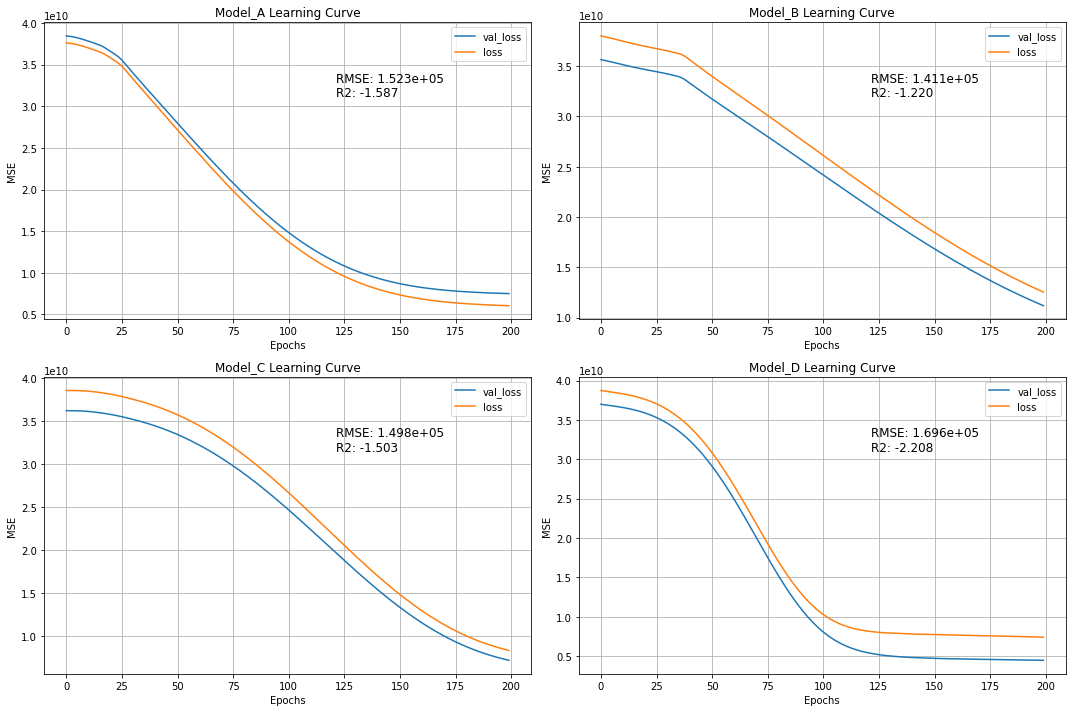

Text(0.5, 0.98, 'Learning Curves')

<Figure size 432x288 with 0 Axes>

In [28]:
# overall summaries, learning curves and test errors
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
flat_axes = axes.flatten()
for i, (model_name,report) in enumerate(best_models_reports.items()):
    report_df = pd.DataFrame(report["history"].history)[["val_loss", "loss"]]
    report_df.plot(ax=flat_axes[i], title=f"{model_name} Learning Curve")
    flat_axes[i].annotate(f"RMSE: {report['test_score']['rmse']:.3e}", xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12)
    flat_axes[i].annotate(f"R2: {report['test_score']['r2']:.3f}", xy=(0.6, 0.75), xycoords='axes fraction', fontsize=12)
    flat_axes[i].set_xlabel("Epochs")
    flat_axes[i].set_ylabel("MSE")
    flat_axes[i].grid(True)
plt.tight_layout()
plt.show()
plt.suptitle("Learning Curves", fontsize=20)

```python

"""
overall Model C performs the best 
"""

```

```markdown
## Combining Technical Analysis Indicators with 2D CNN on Bitcoin Direction Prediction

adding technical analysis indicators to original series, which will help us convert it into 2D Image.
We will use the following technical indicators from TA-Lib library in Python: MACD, RSI, CMO, MOM, Bollinger Bands, SMA. 
Our train period is 2021-2022 and test period will be 2022-2023.

We will use historical 6 days closing price, build up 6x6 image by calculating technical indicators, and predict the direction for the next day (whether the price will be up or down).
We will use a single convolutional layer followed by Fully Connected Layer where kernel size=(2,2) can be set. 
```

In [29]:
try:
    import yfinance
    import talib
except:
    ! pip install yfinance -q
    ! conda install -c conda-forge ta-lib -y -q

In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib as ta


In [31]:
""" 
Helper functions
"""
def download_crypto_data(symbols : list, start_date : str,  end_date : str,save_as = "data/crypto_data.csv"):
    print(f"Downloading data...")
    # get data
    data = yf.download(symbols, 
                    start=start_date, 
                    end=end_date, 
                    progress=False)
    sp_prices_df = pd.DataFrame(data["Close"])
    #save data
    print(f"Saving data ... ")
    Path(save_as).parent.mkdir(parents=True, exist_ok=True)
    sp_prices_df.to_csv(save_as)

In [32]:
symbols = ['BTC-USD'] 
train_start_date = '2021-01-01'
train_end_date = '2022-12-31'
test_start_date = '2022-12-31'
test_end_date = '2023-12-31'

# load data (download if not already downloaded)
file_to_load = f"{DATA_DIR}/bitcoin_data.csv"
if not Path(file_to_load).exists():
    download_crypto_data(symbols, 
                         start_date = train_start_date, 
                         end_date = test_end_date,
                         save_as = file_to_load
                         )
data = pd.read_csv(file_to_load, parse_dates =True, index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1079 entries, 2021-01-01 to 2023-12-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1079 non-null   float64
dtypes: float64(1)
memory usage: 16.9 KB


In [33]:
# add technical indicators
#MACD, RSI, CMO, MOM, Bollinger Bands, SMA
data['MACD'], _, _ = ta.MACD(data['Close'], fastperiod=14, slowperiod=26, signalperiod=9)
data['RSI'] = ta.RSI(data['Close'], timeperiod=14)
data['CMO'] = ta.CMO(data['Close'], timeperiod=14)
data['MOM'] = ta.MOM(data['Close'], timeperiod=14)
data['SMA'] = ta.SMA(data['Close'], timeperiod=14)

#build target variable
daily_returns = data['Close'].pct_change()
# data["Direction"] = daily_returns.apply(lambda x: 1 if x >= 0 else x if np.isnan(x) else -1)
data['Target'] = daily_returns.apply(lambda x: 1 if x >= 0 else x if np.isnan(x) else 0)


In [34]:
# drop missing values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1046 entries, 2021-02-03 to 2023-12-15
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1046 non-null   float64
 1   MACD    1046 non-null   float64
 2   RSI     1046 non-null   float64
 3   CMO     1046 non-null   float64
 4   MOM     1046 non-null   float64
 5   SMA     1046 non-null   float64
 6   Target  1046 non-null   float64
dtypes: float64(7)
memory usage: 65.4 KB


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

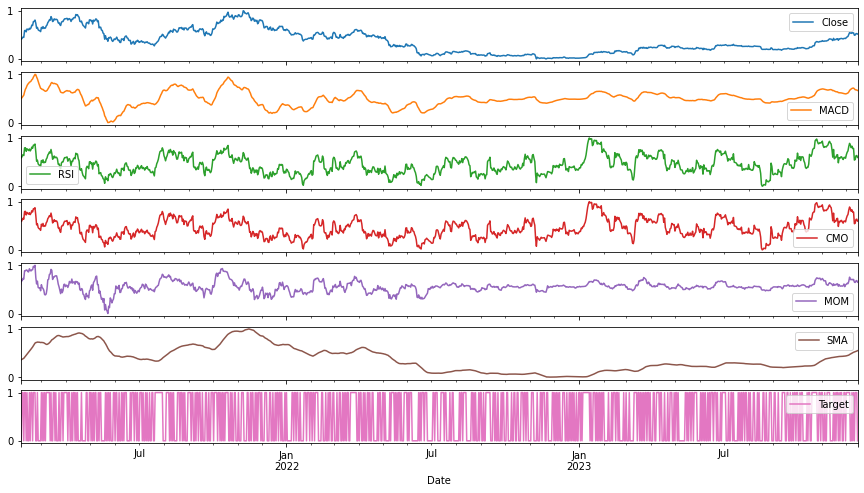

In [35]:
# normalize data

""" It is sufficient to plot scaled data since it retains the same shape as the original data"""

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = pd.DataFrame(scaler.fit_transform(data) , columns=data.columns, index=data.index)
scaled_data.plot(subplots=True, figsize=(15, 8))


In [36]:
# split data into train and test
# separate the features from the target
train_data = scaled_data.loc[train_start_date:train_end_date]
test_data = scaled_data.loc[test_start_date:test_end_date]

X_train , y_train = train_data.drop('Target', axis=1),train_data['Target']
X_test,y_test = test_data.drop('Target', axis=1), test_data['Target']

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((697, 6), (697,), (350, 6), (350,))

In [37]:
# seqToImages
def to_windows(X, y, winSize=6):
    """
    Convert a sequence to images
    """
    _x = []
    _y = []
    for i in range(len(X)-winSize-1):
       _x.append(X[i:i+winSize].values)
       _y.append(y[i+winSize])
    return np.array(_x,dtype=np.float32), np.array(_y,dtype=np.int8)

windowSize = 6
X_train, y_train = to_windows(X_train, y_train, windowSize)
X_test, y_test = to_windows(X_test, y_test, windowSize)


print(f"Before :",X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# expand dims for CNN
X_train,X_test = np.expand_dims(X_train, axis=-1), np.expand_dims(X_test, axis=-1)
y_train,y_test = np.expand_dims(y_train, axis=-1), np.expand_dims(y_test, axis=-1)
# target to categorical
print(f"After:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)




Before : (690, 6, 6) (690,) (343, 6, 6) (343,)
After: (690, 6, 6, 1) (690, 1) (343, 6, 6, 1) (343, 1)


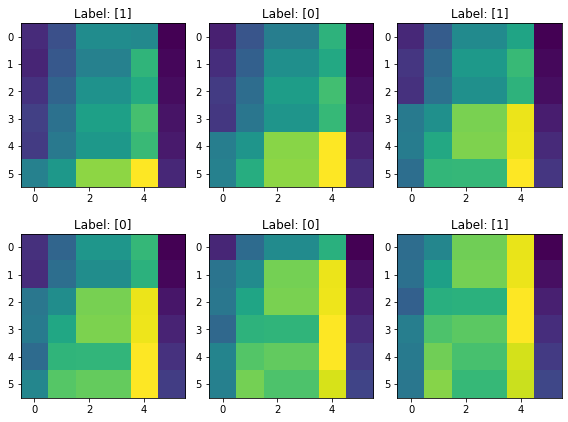

In [38]:
# take a look at the data
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))
flat_axes = axes.flatten()
for i, (data, label) in enumerate(zip(X_train[:6], y_train[:6])):
    flat_axes[i].imshow(data.squeeze())
    flat_axes[i].set_title(f"Label: {label}")
plt.tight_layout()
plt.show()

In [39]:
# build the model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import KFold
from tqdm.keras import TqdmCallback
    
    
model = Sequential(name="CNN")
model.add(Conv2D(8,kernel_size =2, strides =1, activation='relu', input_shape=(6,6,1)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))   

model.summary()


Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 8)           40        
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense_50 (Dense)            (None, 8)                 1608      
                                                                 
 dense_51 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,657
Trainable params: 1,657
Non-trainable params: 0
_________________________________________________________________


In [40]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
              loss=keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=optimizer, 
              metrics=[keras.metrics.BinaryAccuracy(name="acc")]
              )

# monitor = EarlyStopping(monitor='val_loss', min_delta=1, patience=5, verbose=2, mode='auto') 

history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    shuffle=True,
                    batch_size =128, 
                    callbacks=[TqdmCallback(verbose=1)],
                    verbose=0,
                    epochs = 200)

100%|██████████| 200/200 [00:07<00:00, 26.88epoch/s, loss=0.667, acc=0.614, val_loss=0.679, val_acc=0.587]


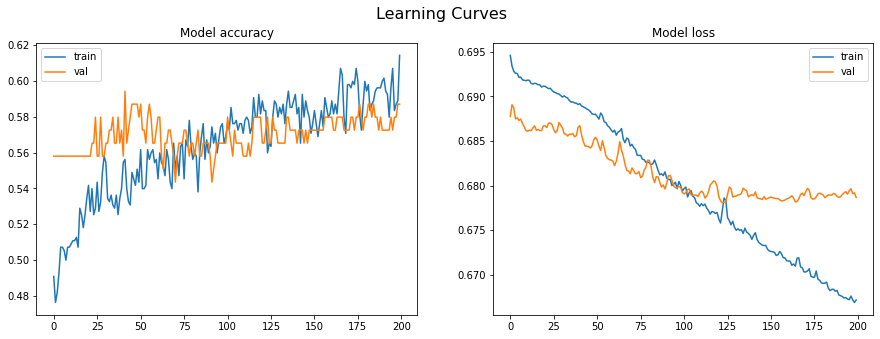

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))


plt.suptitle("Learning Curves", fontsize=16)
axes[0].plot(history.history['acc'], label='train')
axes[0].plot(history.history['val_acc'], label='val',axes=axes[0])
axes[0].set_title('Model accuracy')
axes[0].legend()
# axes[0].xlabel("Epochs")

axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='val')
axes[1].set_title('Model loss')
axes[1].legend()
# axes[1].xlabel("Epochs")


In [42]:
predictions_results = model.evaluate(X_test, y_test)
print(f"Test Loss: {predictions_results[0]:.3e} | Test Accuracy: {predictions_results[1]:.3f}")

11/11 [==============================] - 0s 1ms/step - loss: 0.7172 - acc: 0.4898
Test Loss: 7.172e-01 | Test Accuracy: 0.490


11/11 [==============================] - 0s 1ms/step


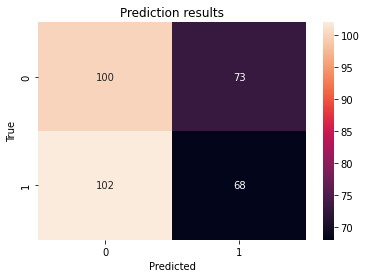

In [43]:
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Prediction results')
plt.show()

```python 
"""
we observe that the model is doing 50,50 
"""
```

```markdown 
## Multivariate LSTM for Predicting EPS (Earnings per Share) over Company Fundamentals

focus on predicting Earnings Per Share (EPS) by jointly modeling historical fundamentals where fundamentals for multiple companies. Number of latent dimension of LSTM can be [5, 10, 30] and the best one can be determined by hyperparameter search.

Evaluation metric will be MAPE score.
```

In [3]:
# read the data 

path_to_data = Path(f'{DATA_DIR}/household_power_consumption.txt')
data = pd.read_csv(path_to_data, parse_dates =True, index_col=0)
# infer data types
data = data.infer_objects()

# handle  missing values
columns_with_missing_values= data.columns[data.isnull().any()]
display(data[columns_with_missing_values].isnull().sum())


Cash Ratio                      299
Current Ratio                   299
Quick Ratio                     299
For Year                        173
Earnings Per Share              219
Estimated Shares Outstanding    219
dtype: int64

In [4]:
# for simplicity I will drop nans
data.dropna(inplace=True,axis=0)
data.shape

(1299, 78)

In [5]:
# data.info()
target_column = "Earnings Per Share"

companies = data['Ticker Symbol'].unique()

# encode companies
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(companies)

LabelEncoder()

In [6]:
#normalize all but target
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1,1))
numerical_columns = data.select_dtypes(include=['number']).columns
normalized_data = pd.DataFrame(scaler.fit_transform(data[numerical_columns]), columns=numerical_columns, index=data.index)
normalized_data[target_column] = data[target_column]
data[numerical_columns] = normalized_data[numerical_columns]
data.shape , data.shape

((1299, 78), (1299, 78))

In [7]:
# data[target_column].describe()
# normalized_data[target_column].plot.hist(bins=100, 
#                               figsize=(8, 5),
#                               fontsize=14, 
#                               grid=True, 
#                               title="Earnings Per Share Distribution")

In [8]:
## 
def to_sub_sequences(seq, winsize = 2, target_column = "Earnings Per Share"):
    
    X = []
    y = []
    seq_X = seq.drop(target_column, axis=1).values
    seq_y = seq[target_column].values
    
    for i in range(winsize, len(seq)+1):
        X.append(seq_X[i-winsize:i])
        y.append(seq_y[i-1])
        
    return np.array(X), np.array(y)
    

In [9]:
# create per company sequences 

"""

We can not blindly partition sequences ( it needs to be company based)
"""

sequence_length = 2 # 2 years

per_company_sequence = []
for company in companies:
    company_data = data[data['Ticker Symbol'] == company].sort_values('Period Ending')
    #encode cat
    company_data['Ticker Symbol'] = label_encoder.transform(company_data['Ticker Symbol'])
    company_data.set_index("Period Ending",inplace=True)
    
    # create sequences
    per_company_X, per_company_y = to_sub_sequences(company_data, winsize = sequence_length, target_column = target_column)
    per_company_sequence.append((per_company_X, per_company_y))
    
len(per_company_sequence)

360

In [10]:
# compile X and y for all companies
X = []
y = []
for company_X, company_y in per_company_sequence:
    X.extend(company_X)
    y.extend(company_y)

seq_X , seq_y= np.array(X), np.array(y)
seq_X.shape , seq_y.shape

((939, 2, 76), (939,))

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from tqdm.keras import TqdmCallback
from sklearn.metrics import mean_absolute_percentage_error

In [12]:
# now we can split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(seq_X, seq_y, test_size=0.2, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((751, 2, 76), (751,), (188, 2, 76), (188,))

In [13]:
def create_lstm_model(latent_dim, input_shape):
    model = Sequential(name=f"LSTM-{latent_dim}")
    model.add(LSTM(latent_dim, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(128, return_sequences=False))    
    model.add(Dense(32))
    model.add(Dense(8))
    model.add(Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=0.0001) 
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics =[tf.keras.losses.MeanAbsolutePercentageError(name="mape"),
                            tf.keras.metrics.MeanAbsoluteError(name="mae")]
                  )  
    return model

In [14]:
# train the model
latent_dim = 128
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_lstm_model(latent_dim, input_shape)
# model.summary()

# monitor = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1, patience=5, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath=f"models/lstm-{latent_dim}.keras", verbose=0, save_best_only=True)
tqdm_callback = TqdmCallback(verbose=1)

history = model.fit(X_train, y_train, 
                    validation_split=0.2,
                    shuffle=True,
                    epochs=30, 
                    batch_size=128, 
                    verbose=0,
                    callbacks=[tqdm_callback,checkpointer])

100%|██████████| 30/30 [00:04<00:00,  6.83epoch/s, loss=29.5, mape=148, mae=2.59, val_loss=13.9, val_mape=102, val_mae=2.18] 


Text(0, 0.5, 'Loss (MSE)')

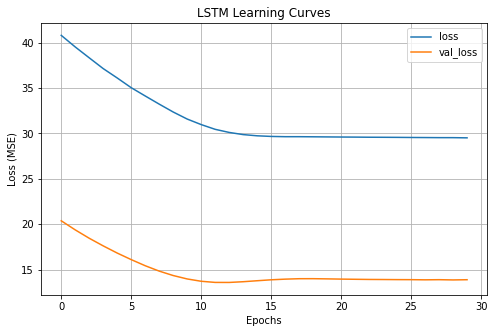

In [15]:
# history_df = pd.DataFrame(history.history)
history_df = pd.DataFrame(history.history)[["loss", "val_loss"]]
history_df.plot(grid=True, figsize=(8, 5), title="LSTM Learning Curves", legend=True)
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")

In [16]:
preds = model.predict(np.array(X_test))
mape = 100 * mean_absolute_percentage_error(y_test, preds)

""" 
Based on MAPE, we want our models to minimize the error as much as possible.
we could therefore say that overal the model in not performing that well 
"""
print(f"MAPE: {mape:.3f} %")


6/6 [==============================] - 0s 3ms/step
MAPE: 236.513 %


**Now with Gridsearch to decide best latent dimension**

```python
"""
    we observe that the best latent dimension is 30
"""
```

In [17]:

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor


# Perform grid search
lstm_regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)

param_grid = {
    'latent_dim': [5, 10, 30],
    "input_shape": [(X_train.shape[1], X_train.shape[2])]
}

grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, scoring='neg_mean_absolute_percentage_error', cv=3)
grid_result = grid.fit(X_train, y_train)

# Get the best parameters and best MAPE score
best_params = grid_result.best_params_
best_mape = - grid_result.best_score_

print("Best Parameters:", best_params)
print(f"Best MAPE:{100* best_mape}")

# Finally, fit the best model on the entire training data and evaluate on the test set
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

preds = best_model.predict(np.array(X_test))
mape = 100 * mean_absolute_percentage_error(y_test, preds)
print(f"MAPE on Test Set: {mape:.3f} %")

Best Parameters: {'input_shape': (2, 76), 'latent_dim': 30}
Best MAPE:95.28721036302477
MAPE on Test Set: 97.492 %
